*This notebook was created by Sergey Tomin (sergey.tomin@desy.de). Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). April 2025.*

# Ocelot for Students

This is a simple example designed to help students and beginners who are just starting to study accelerator physics.  
It aims to build intuition about how magnetic elements work.

## Quadrupole Doublet

In this section, we will consider a simple beamline consisting of only a drift and two quadrupoles.

As usual, let's import the necessary Ocelot modules, the standard Python `copy` library, and `ipywidgets` for interaction with the physics model.

> 💡 **Tip:** If you don't have the `ipywidgets` module installed, just search online for installation instructions:  
> `pip install ipywidgets`

In [1]:
from ocelot import *
from ocelot.gui import *
from ipywidgets import interact, FloatSlider
import copy

initializing ocelot...


## Create a simple lattice

In [2]:
d = Drift(l=1.)
qf = Quadrupole(l=0.2, k1=1)
qd = Quadrupole(l=0.2, k1=-1)
cell = [d, qf, d, qd, d]

lat = MagneticLattice(cell)

## Let's Create a Simple Function to Plot Beta Functions

Now we define a function that calculates and plots the beta functions for a simple lattice with a focusing and defocusing quadrupole.  
You can interactively change the quadrupole strengths using sliders (if using `ipywidgets`), and observe how the beta functions evolve.

In [3]:
# Define a function that depends on some parameters
def plot_betas(qf_k1=1.0, qd_k1=-1.0, save_path=None):
    # Set quadrupole strengths
    qf.k1 = qf_k1
    qd.k1 = qd_k1

    # Define initial Twiss parameters
    tws0 = Twiss(beta_x=10, beta_y=10, alpha_x=0, alpha_y=0)

    # Calculate Twiss parameters along the beamline
    tws = twiss(lat, tws0, nPoints=20)

    # Extract s-position and beta functions
    sb = [tw.s for tw in tws]
    bx = [tw.beta_x for tw in tws]
    by = [tw.beta_y for tw in tws]

    # Plot using Ocelot's built-in function (you can also use matplotlib directly)
    fig, ax_xy = plot_API(lat, fig_name=f"Beta-functions: QF.k1={qf_k1:.2f}, QD.k1={qd_k1:.2f}", legend=False)
    fig.suptitle(f"Beta-functions: QF.k1={qf_k1:.2f}, QD.k1={qd_k1:.2f}")

    ax_xy.plot(sb, bx, "C1", label=r"$\beta_x$")
    ax_xy.plot(sb, by, "C2", label=r"$\beta_y$")
    ax_xy.set_ylabel(r"$\beta_{x,y}$ [m]")
    ax_xy.set_xlabel("S [m]")
    ax_xy.legend()
    if save_path:
        fig.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [4]:
# Create interactive sliders for the parameters
interact(
    lambda qf_k1,qd_k1: plot_betas(qf_k1,qd_k1, save_path=None),
    qf_k1=FloatSlider(min=-20, max=20, step=0.1, value=1.0),
    qd_k1=FloatSlider(min=-20, max=20, step=0.1, value=-1.0),
)

interactive(children=(FloatSlider(value=1.0, description='qf_k1', max=20.0, min=-20.0), FloatSlider(value=-1.0…

<function __main__.<lambda>(qf_k1, qd_k1)>

## Plot Trajectories for Better Understanding of Transverse Beam Dynamics

Now let's plot particle trajectories with initial transverse offsets to better visualize how the beam evolves through the lattice.

We’ll use two subplots: one for horizontal (`x`) and one for vertical (`y`) motion.

In [5]:
def plot_beam(qf_k1=1.0, qd_k1=-1.0, save_path=None):
    qf.k1 = qf_k1
    qd.k1 = qd_k1

    x_coors = np.linspace(-0.01, 0.01, num=10)
    y_coors = np.linspace(-0.01, 0.01, num=10)

    p_list = [Particle(x=x, y=y) for x, y in zip(x_coors, y_coors)]
    P = [copy.deepcopy(p_list)]
    navi = Navigator(lat)
    dz = 0.01

    for _ in range(int(lat.totalLen / dz)):
        tracking_step(lat, p_list, dz=dz, navi=navi)
        P.append(copy.deepcopy(p_list))
    fig, (ax_x, ax_y) = plot_API(lat, figsize=(10,6), legend=False, add_extra_subplot=True)
    fig.suptitle(f"Particle Trajectories with Transverse Offsets: QF.k1={qf_k1:.2f}, QD.k1={qd_k1:.2f}")

    for i in range(len(p_list)):
        s = [p[i].s for p in P]
        x = [p[i].x for p in P]
        y = [p[i].y for p in P]
        ax_x.plot(s, x, "C0")
        ax_y.plot(s, y, "C1")

    ax_x.set_ylabel("X [m]")
    ax_y.set_ylabel("Y [m]")
    ax_x.grid(True)
    ax_y.grid(True)
    if save_path:
        fig.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [6]:
# Create interactive sliders for the parameters
interact(
    lambda qf_k1,qd_k1: plot_beam(qf_k1,qd_k1, save_path=None),
    qf_k1=FloatSlider(min=-20, max=20, step=0.1, value=1.0),
    qd_k1=FloatSlider(min=-20, max=20, step=0.1, value=-1.0),
)

interactive(children=(FloatSlider(value=1.0, description='qf_k1', max=20.0, min=-20.0), FloatSlider(value=-1.0…

<function __main__.<lambda>(qf_k1, qd_k1)>

## Bending Magnet: Quick Look at Dispersion

Let's take a look at transverse beam dynamics in a dipole magnet.

### A Simple Lattice

We define a basic beamline composed of a drift–dipole–drift sequence:


In [7]:
d = Drift(l=1)
b1 = Bend(l=0.5, angle=5/180*np.pi, e1=0, e2=0)
cell = [d, b1, d]
lat2 = MagneticLattice(cell)

### Dispersion Visualization
Now we’ll create particles with zero initial transverse coordinates, but different momentum deviations, and observe how this affects their horizontal position.
In other words, we’ll see dispersion in action 😊

In [8]:
def plot_dipole_disp(angle=0.01, save_path=None):
    # Set dipole parameters (angle in degrees -> radians)
    b1.angle = angle * np.pi / 180
    b1.e1 = 0 # edge focusing is 0 Basically it is SBend magnet
    b1.e2 = 0 # edge focusing is 0 Basically it is SBend magnet
    print(f"Lattice length: {lat2.totalLen:.2f} m")

    # Create particles with momentum deviations (x = 0, y = 0)
    p_coors = np.linspace(-0.01, 0.01, num=10)
    p_list = [Particle(x=0, y=0, p=p, E=1) for p in p_coors]
    P = [copy.deepcopy(p_list)]

    # Navigator and tracking step size
    navi = Navigator(lat2)
    dz = 0.01

    # Track particles through the lattice
    for _ in range(int(lat2.totalLen / dz)):
        tracking_step(lat2, p_list, dz=dz, navi=navi)
        P.append(copy.deepcopy(p_list))

    # Plot horizontal trajectories and momenta
    fig, (ax_x, ax_p) = plot_API(lat2, figsize=(10,6), legend=False, add_extra_subplot=True)

    fig.suptitle(f"Effect of Dispersion in a Dipole Magnet: Angle = {angle:.1f}")

    colors = plt.cm.rainbow(np.linspace(0, 1, len(p_list)))[::-1]
    for i in range(len(p_list)):
        s = [p[i].s for p in P]
        x = [p[i].x for p in P]
        p_vals = [p[i].p for p in P]

        ax_x.plot(s, x, color=colors[i])
        ax_p.plot(s, p_vals, color=colors[i])

    ax_x.set_ylabel("X [m]")
    ax_p.set_ylabel("Relative Momentum p")
    ax_x.set_ylim([-0.005, 0.005])

    ax_x.grid(True)
    ax_p.grid(True)
    if save_path:
        fig.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [9]:
# Create interactive sliders for the parameters
interact(
    lambda angle: plot_dipole_disp(angle=angle, save_path=None),
    angle=FloatSlider(min=-30, max=30, step=0.05, value=1.0),
)

interactive(children=(FloatSlider(value=1.0, description='angle', max=30.0, min=-30.0, step=0.05), Output()), …

<function __main__.<lambda>(angle)>

## Do Bending Magnets Focus the Beam?

In this section, we investigate whether bending magnets can provide transverse focusing. We'll compare two common types of dipole magnets used in accelerator physics: the **sector dipole magnet** (`SBend`) and the **rectangular dipole magnet** (`RBend`). Each has distinct edge geometries, which affect how the beam is focused or defocused in the transverse plane.

---

### Sector Dipole Magnet (`SBend`)

A **sector dipole** has its entrance and exit faces aligned **perpendicular to the reference trajectory**. 

![SBend](sbend.png)

In the animation below, you can see how a beam propagates through an `SBend`, and how the transverse position evolves due to the edge focusing.


In [10]:
# Assuming these come from your simulation code
# from your_code import Drift, SBend, MagneticLattice, Navigator, Particle, tracking_step

# Setup lattice (this stays outside the function)
d = Drift(l=1)
b = SBend(l=0.5, angle=5/180*np.pi)
cell = [d, b, d]
lat3 = MagneticLattice(cell)

def plot_sbend_focus(angle=0.01, save_path=None):
    b.angle = angle * np.pi / 180
    b.e1 = 0
    b.e2 = 0
    x_coors = np.linspace(-0.01, 0.01, num=10)
    p_list = [Particle(x=x, y=x, p=0, E=1) for x in x_coors]
    P = [copy.deepcopy(p_list)]

    navi = Navigator(lat3)
    dz = 0.01

    for _ in range(int(lat3.totalLen / dz)):
        tracking_step(lat3, p_list, dz=dz, navi=navi)
        P.append(copy.deepcopy(p_list))
    fig, (ax_x, ax_y) = plot_API(lat3, figsize=(10,6), legend=False, add_extra_subplot=True)
    fig.suptitle(f"Sector Magnet: Focusing  Effect: Angle = {angle:.1f}°")

    for i in range(len(p_list)):
        s = [p[i].s for p in P]
        x = [p[i].x for p in P]
        y = [p[i].y for p in P]

        ax_x.plot(s, x, "C0")
        ax_y.plot(s, y, "C1")

    ax_x.set_ylabel("X [m]")
    ax_y.set_ylabel("Y [m]")
    ax_x.grid(True)
    ax_y.grid(True)

    if save_path:
        fig.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()


In [11]:
# Create interactive sliders for the parameters
interact(
    lambda angle: plot_sbend_focus(angle=angle, save_path=None),
    angle=FloatSlider(min=-90, max=90, step=1, value=0),)

interactive(children=(FloatSlider(value=0.0, description='angle', max=90.0, min=-90.0, step=1.0), Output()), _…

<function __main__.<lambda>(angle)>

### Rectangular Dipole Magnet (`RBend`)

The **rectangular dipole** is simpler and more common in practice due to ease of manufacturing. Unlike the `SBend`, in a rectangular dipole the entrance and exit faces are **perpendicular to the magnet body**, not to the beam trajectory. As a result, the beam enters and exits the magnet at an angle of $ \phi/2 $ with respect to the face of the magnet, where $ \phi $ is the total bending angle.


![RBend](rbend.png)

The animation below demonstrates how a beam behaves when passing through an `RBend`, illustrating the distinct focusing effect caused by the non-normal incidence at the edges.


In [12]:
# Assuming these come from your simulation code
# from your_code import Drift, SBend, MagneticLattice, Navigator, Particle, tracking_step

# Setup lattice (this stays outside the function)
d = Drift(l=1)
b = RBend(l=0.5, angle=5/180*np.pi)
cell = [d, b, d]
lat3 = MagneticLattice(cell)

def plot_rbend_focus(angle=0.01, save_path=None):
    b.angle = angle * np.pi / 180
    b.e1 = b.angle/2 # edge angle is not changing automatcally it has to be also set 
    b.e2 = b.angle/2 # edge angle is not changing automatcally it has to be also set 
    
    x_coors = np.linspace(-0.01, 0.01, num=10)
    p_list = [Particle(x=x, y=x, p=0, E=1) for x in x_coors]
    P = [copy.deepcopy(p_list)]

    navi = Navigator(lat3)
    dz = 0.01

    for _ in range(int(lat3.totalLen / dz)):
        tracking_step(lat3, p_list, dz=dz, navi=navi)
        P.append(copy.deepcopy(p_list))
    
    fig, (ax_x, ax_y) = plot_API(lat3, figsize=(10,6), legend=False, add_extra_subplot=True)
    fig.suptitle(f"Rectangular Magnet: Focusing  Effect: Angle = {angle:.1f}°")

    for i in range(len(p_list)):
        s = [p[i].s for p in P]
        x = [p[i].x for p in P]
        y = [p[i].y for p in P]

        ax_x.plot(s, x, "C0")
        ax_y.plot(s, y, "C1")

    ax_x.set_ylabel("X [m]")
    ax_y.set_ylabel("Y [m]")
    ax_x.grid(True)
    ax_y.grid(True)
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        fig.savefig(save_path)
        plt.close(fig)
    else:
        plt.show()

In [13]:
# Create interactive sliders for the parameters
interact(
    lambda angle: plot_rbend_focus(angle=angle, save_path=None),
    angle=FloatSlider(min=-90, max=90, step=1, value=0),)

interactive(children=(FloatSlider(value=0.0, description='angle', max=90.0, min=-90.0, step=1.0), Output()), _…

<function __main__.<lambda>(angle)>

# Appendix
## Generate GIF

In [14]:
import os
from imageio import get_writer
from IPython.display import Image

os.makedirs("frames", exist_ok=True)

angles = np.linspace(-90, 90, 90)  # e.g. 30 frames from -30° to +30°
filenames = []

for i, angle in enumerate(angles):
    filename = f"frames/frame_{i:03d}.png"
    plot_sbend_focus(angle=angle, save_path=filename)
    filenames.append(filename)

In [15]:
import imageio.v2 as imageio

with imageio.get_writer("sbend.gif", mode="I", duration=0.1, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)  # ✅ FIXED
        writer.append_data(image)

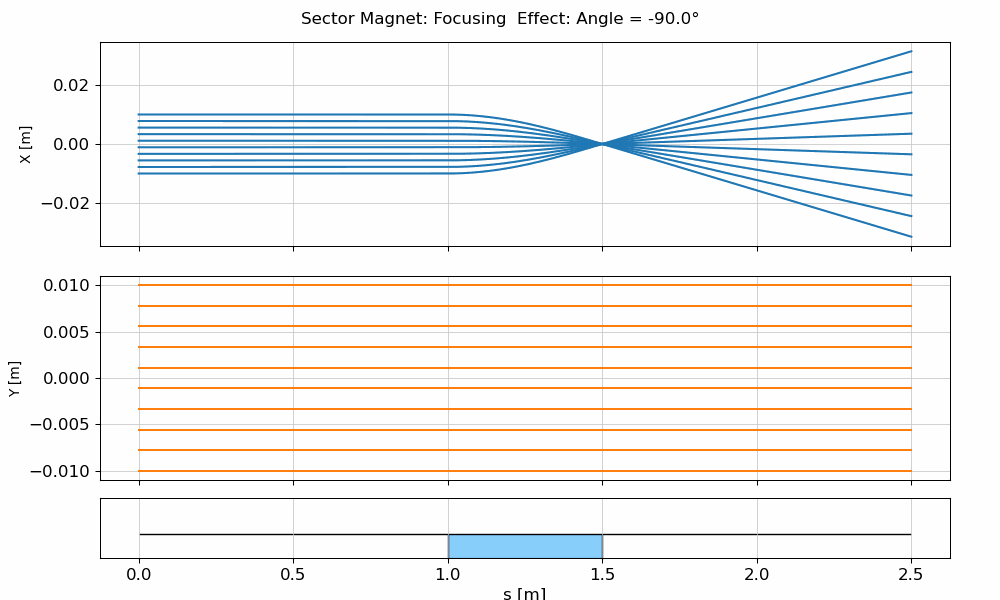

In [16]:
Image(filename="sbend.gif")

## Generate GIF with two variables 

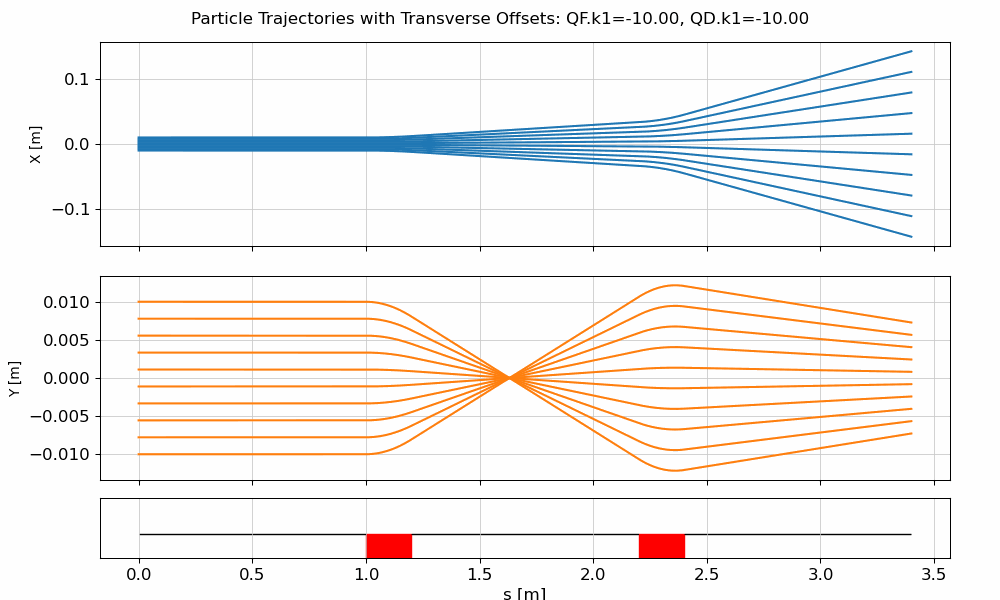

In [17]:
os.makedirs("quad_scan_frames", exist_ok=True)
filenames = []

# --- Part 1: Vary qf_k1, fix qd_k1 ---
qf_values = np.linspace(-10, 10, 50)
qd_fixed = -10.0

for i, qf_k1 in enumerate(qf_values):
    filename = f"quad_scan_frames/frame_qf_{i:03d}.png"
    plot_beam(qf_k1=qf_k1, qd_k1=qd_fixed, save_path=filename)
    filenames.append(filename)

# --- Part 2: Vary qd_k1, fix qf_k1 ---
qd_values = np.linspace(-10, 10, 50)
qf_fixed = 10.0

for i, qd_k1 in enumerate(qd_values):
    filename = f"quad_scan_frames/frame_qd_{i:03d}.png"
    plot_beam(qf_k1=qf_fixed, qd_k1=qd_k1, save_path=filename)
    filenames.append(filename)

with get_writer("quad_scan_beam.gif", mode="I", duration=0.1, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

Image("quad_scan_beam.gif")

## Generate simple plots of dipoles

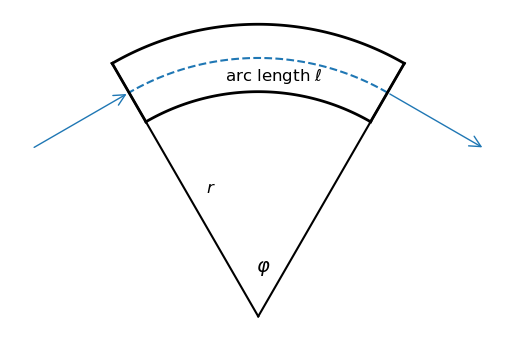

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
phi_deg = 60                    # Central angle in degrees
phi = np.deg2rad(phi_deg)      # Convert to radians
r_inner = 1.0                   # Inner radius
thickness = 0.3                # Thickness of the annular sector
r_outer = r_inner + thickness  # Outer radius
r_particle = r_inner + thickness / 2 

# Create angle array
theta = np.linspace(np.pi/2 - phi/2, np.pi/2 + phi/2, 100)

# Create figure and axis
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

# Draw inner arc
x_inner = r_inner * np.cos(theta)
y_inner = r_inner * np.sin(theta)


ax.plot(x_inner, y_inner, 'k', lw=2)

# Draw outer arc
x_outer = r_outer * np.cos(theta)
y_outer = r_outer * np.sin(theta)
ax.plot(x_outer, y_outer, 'k',lw=2)

x_traj = r_particle * np.cos(theta)
y_traj = r_particle * np.sin(theta)

ax.plot(x_traj, y_traj, "--")

# Draw radial lines
ax.plot([x_inner[0], x_outer[0]], [y_inner[0], y_outer[0]], 'k', lw=2)
ax.plot([x_inner[-1], x_outer[-1]], [y_inner[-1], y_outer[-1]], 'k', lw=2)

ax.plot([0, x_outer[0]], [0, y_outer[0]], 'k')
ax.plot([0, x_outer[-1]], [0, y_outer[-1]], 'k')
# Label angle
ax.text(-0.01, 0.2, r'$\varphi$', fontsize=14)

# Label arc length
mid_theta =  np.pi/2
arc_x = (r_particle ) * np.cos(mid_theta)
arc_y = (r_particle - 0.1) * np.sin(mid_theta)
ax.text(arc_x -0.15, arc_y, "arc length $\\ell$", fontsize=12, rotation=0)

# Label 90° angles
#ax.text(0.55, 0.05, rf'${phi_deg}^\circ$', fontsize=12)
#ax.text(0.05, 1, rf'${phi_deg}^\circ$', fontsize=12)

# Label radius
radius_x = r_inner/2 * np.cos(phi + np.pi/2)
radius_y = r_inner/2 * np.sin(phi + np.pi/2)
ax.text(radius_x + 0.2, radius_y + 0.3, r'$r$', fontsize=12)
length = 0.5
#ax.arrow(x=x_traj[0], y=y_traj[0], dx=np.cos(phi/2)*length, dy=-np.sin(phi/2)*length, width=0.005, head_width=0.05, head_length=0.1, fc='C0', ec='C0')
#ax.arrow(x=x_traj[-1], y=y_traj[-1], dx=-np.cos(phi/2)*length, dy=-np.sin(phi/2)*length, width=0.005, head_width=0.05, head_length=0.1, fc='C0', ec='C0')
from matplotlib.patches import FancyArrowPatch

arrow = FancyArrowPatch(posA=(x_traj[0], y_traj[0]), 
                        posB=(x_traj[0] + np.cos(phi/2)*length, y_traj[0]-np.sin(phi/2)*length),
                        arrowstyle='->', color='C0', mutation_scale=20)
ax.add_patch(arrow)

# Reversed direction
reverse_arrow = FancyArrowPatch(posA=(x_traj[-1], y_traj[-1]), 
                                 posB=(x_traj[-1]-np.cos(phi/2)*length, y_traj[-1]-np.sin(phi/2)*length),
                                 arrowstyle='<-', color='C0', mutation_scale=20)
ax.add_patch(reverse_arrow)
# Hide axes
ax.axis('off')
#ax.set_xlim(-0.2, r_outer + 0.2)
#ax.set_ylim(-0.2, r_outer + 0.6)

plt.show()

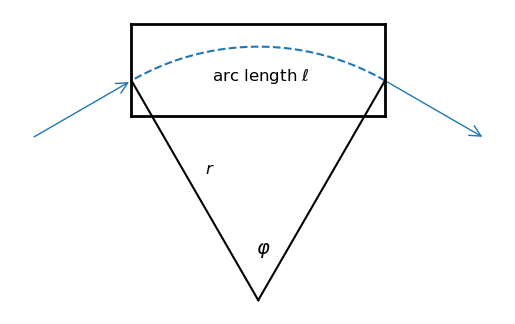

In [19]:
# Parameters
phi_deg = 60                    # Central angle in degrees
phi = np.deg2rad(phi_deg)      # Convert to radians
r_inner = 1.0                   # Inner radius
thickness = 0.2                # Thickness of the annular sector
r_particle = r_inner + thickness / 2 

# Create angle array
theta = np.linspace(np.pi/2 - phi/2, np.pi/2 + phi/2, 100)

# Create figure and axis
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})


x_traj = r_particle * np.cos(theta)
y_traj = r_particle * np.sin(theta)

ax.plot(x_traj, y_traj, "--")

ax.plot([x_traj[0], x_traj[0]], [0.8, 1.2], "k", lw=2)
ax.plot([x_traj[-1], x_traj[-1]], [0.8, 1.2], "k", lw=2)
ax.plot([x_traj[0], x_traj[-1]], [0.8, 0.8], "k", lw=2)
ax.plot([x_traj[0], x_traj[-1]], [1.2, 1.2], "k", lw=2)

# Draw radial lines
ax.plot([0, x_traj[0]], [0, y_traj[0]], 'k')
ax.plot([0, x_traj[-1]], [0, y_traj[-1]], 'k')
# Label angle
ax.text(-0.01, 0.2, r'$\varphi$', fontsize=14)

# Label arc length
mid_theta =  np.pi/2
arc_x = (r_particle - 0.2) * np.cos(mid_theta)
arc_y = (r_particle - 0.15) * np.sin(mid_theta)
ax.text(arc_x-0.2, arc_y, "arc length $\\ell$", fontsize=12, rotation=0)

# Label 90° angles
#ax.text(0.55, 0.05, rf'${phi_deg}^\circ$', fontsize=12)
#ax.text(0.05, 1, rf'${phi_deg}^\circ$', fontsize=12)

# Label radius
radius_x = r_inner/2 * np.cos(phi + np.pi/2)
radius_y = r_inner/2 * np.sin(phi + np.pi/2)
ax.text(radius_x + 0.2, radius_y + 0.3, r'$r$', fontsize=12)
length = 0.5
#ax.arrow(x=x_traj[0], y=y_traj[0], dx=np.cos(phi/2)*length, dy=-np.sin(phi/2)*length, width=0.005, head_width=0.05, head_length=0.1, fc='C0', ec='C0')
#ax.arrow(x=x_traj[-1], y=y_traj[-1], dx=-np.cos(phi/2)*length, dy=-np.sin(phi/2)*length, width=0.005, head_width=0.05, head_length=0.1, fc='C0', ec='C0')
from matplotlib.patches import FancyArrowPatch

arrow = FancyArrowPatch(posA=(x_traj[0], y_traj[0]), 
                        posB=(x_traj[0] + np.cos(phi/2)*length, y_traj[0]-np.sin(phi/2)*length),
                        arrowstyle='->', color='C0', mutation_scale=20)
ax.add_patch(arrow)

# Reversed direction
reverse_arrow = FancyArrowPatch(posA=(x_traj[-1], y_traj[-1]), 
                                 posB=(x_traj[-1]-np.cos(phi/2)*length, y_traj[-1]-np.sin(phi/2)*length),
                                 arrowstyle='<-', color='C0', mutation_scale=20)
ax.add_patch(reverse_arrow)
# Hide axes
ax.axis('off')
#ax.set_xlim(-0.2, r_outer + 0.2)
#ax.set_ylim(-0.2, r_outer + 0.6)

plt.show()